# Utils

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k: [z for z in zip(*log[k])] for k in keys}
    epochs = {k: range(len(log[k])) for k in keys}

    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

# Data

In [5]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2987923.19it/s]


Extracting ./MNIST_data\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 221664.16it/s]


Extracting ./MNIST_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 440708.34it/s]


Extracting ./MNIST_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4558633.35it/s]

Extracting ./MNIST_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw



# Autoencoder

In [6]:
'''
Этот код определяет два класса Encoder и Decoder для автоэнкодера.

Encoder берет входное изображение размером 28x28 и сжимает его в скрытое
представление (latent representation) заданного размера.

Decoder получает скрытое представление и восстанавливает изображение обратно
к исходным размерам 28x28.

Каждый класс определяет операцию прямого прохода (forward pass),
которая определяет, как данные проходят через слои сети.
'''


# Определение класса Encoder, который является подклассом nn.Module
class Encoder(nn.Module):
    # Инициализация класса Encoder с заданным размером скрытого представления (по умолчанию 10)
    def __init__(self, latent_size=10):
        # Вызов конструктора родительского класса nn.Module
        super(Encoder, self).__init__()
        # Определение полносвязного слоя с входным размером 28*28 (размер изображения MNIST) и выходным размером latent_size
        self.fc1 = nn.Linear(28*28, latent_size)

    # Определение операции прямого прохода (forward pass) для Encoder
    def forward(self, x):
        # Применение сигмоидной функции активации к выходу полносвязного слоя
        x = torch.sigmoid(self.fc1(x))
        return x

# Определение класса Decoder, который является подклассом nn.Module
class Decoder(nn.Module):
    # Инициализация класса Decoder с заданным размером скрытого представления (по умолчанию 10)
    def __init__(self, latent_size=10):
        # Вызов конструктора родительского класса nn.Module
        super(Decoder, self).__init__()
        # Определение полносвязного слоя с входным размером latent_size и выходным размером 28*28 (размер изображения MNIST)
        self.fc1 = nn.Linear(latent_size, 28*28)

    # Определение операции прямого прохода (forward pass) для Decoder
    def forward(self, x):
        # Применение гиперболического тангенса к выходу полносвязного слоя
        x = torch.tanh(self.fc1(x))
        return x


L2-регуляризация (также известная как регуляризация весов или взвешивание) штрафует большие значения весов в модели, заставляя их быть ближе к нулю. Это может привести к тому, что большинство весов станут близкими к нулю, что в свою очередь сделает модель разреженной.



In [7]:
'''
Этот код определяет класс Net, который представляет собой полносвязную
нейронную сеть (autoencoder).

Он состоит из Encoder и Decoder, которые кодируют и декодируют данные
соответственно. В конструкторе определяются основные параметры модели,
такие как размер скрытого представления, функция потерь, скорость обучения
и коэффициент L2-регуляризации.

Метод forward выполняет операцию прямого прохода через сеть.
Метод decode выполняет только декодирование скрытого представления
без вычисления градиентов.

Метод loss вычисляет значение функции потерь для данного входа и целевого выхода.
'''

# Определение класса Net, который является подклассом nn.Module
class Net(nn.Module):
    # Инициализация класса Net с заданными параметрами: размер скрытого представления, функция потерь, скорость обучения, коэффициент L2-регуляризации
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        # Вызов конструктора родительского класса nn.Module
        super(Net, self).__init__()
        # Задание размера скрытого представления
        self.latent_size = latent_size
        # Создание экземпляра класса Encoder с заданным размером скрытого представления
        self.E = Encoder(latent_size)
        # Создание экземпляра класса Decoder с заданным размером скрытого представления
        self.D = Decoder(latent_size)
        # Задание функции потерь
        self.loss_fn = loss_fn
        # Инициализация переменной для хранения значения потери
        self._loss = None
        # Определение оптимизатора Adam для обновления параметров модели
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    # Определение операции прямого прохода (forward pass) для модели
    def forward(self, x):
        # Преобразование входных данных в одномерный вектор
        x = x.view(-1, 28*28)
        # Применение Encoder к входным данным
        h = self.E(x)
        # Применение Decoder к скрытому представлению
        out = self.D(h)
        return out

    # Метод для декодирования скрытого представления
    def decode(self, h):
        # Выполнение декодирования без вычисления градиентов
        with torch.no_grad():
            return self.D(h)

    # Метод для вычисления функции потерь
    def loss(self, x, target, **kwargs):
        # Преобразование целевых данных в одномерный вектор
        target = target.view(-1, 28*28)
        # Вычисление значения функции потерь
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss


Код создает словарь `models` и два словаря `train_log` и `test_log`.

1. `models = {'16': Net(16), '32': Net(32), '64': Net(64)}`:
   - Создается словарь `models`, где ключами являются строки, представляющие размеры скрытого слоя (16, 32 и 64), а значениями - экземпляры класса `Net` с соответствующими размерами скрытого слоя. Таким образом, создается три модели автоэнкодера с разными размерами скрытого слоя.

2. `train_log = {k: [] for k in models}`:
   - Создается словарь `train_log`, который инициализируется пустыми списками для каждой модели из словаря `models`. Этот словарь будет использоваться для записи значений функции потерь на каждой эпохе обучения для каждой модели.

3. `test_log = {k: [] for k in models}`:
   - Создается словарь `test_log`, который также инициализируется пустыми списками для каждой модели из словаря `models`. Этот словарь будет использоваться для записи значений функции потерь на тестовом наборе данных для каждой модели.

Таким образом, после выполнения этого кода у нас есть словарь моделей `models`, в котором содержатся три модели с разными размерами скрытого слоя, и два словаря для записи значений функции потерь в процессе обучения (`train_log`) и на тестовом наборе данных (`test_log`) для каждой модели.

In [8]:
models = {'2': Net(2), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
print(models)

# Многослойный автокодировщик

Этот код определяет функцию `train`, которая выполняет одну эпоху обучения моделей. Внутри функции происходит обучение моделей на всех батчах из обучающего набора данных. В цикле для каждого батча добавляется случайный шум к входным данным, затем применяется каждая модель из словаря моделей к зашумленным данным, вычисляется значение функции потерь и обновляются веса моделей. По завершении эпохи печатаются значения потерь для каждой модели.

In [11]:
def train(epoch, models, log=None, add_noise=None):
    # Определяем размер обучающего набора данных.
    train_size = len(train_loader.sampler)
    # Проходим по каждому батчу в обучающем наборе данных.
    for batch_idx, (data, _) in enumerate(train_loader):
        # Добавляем случайный шум к входным данным.
        if add_noise is not None:
            noized = add_noise(data)
        else:
            noized = data

        # Проходим по каждой модели в словаре моделей.
        for model in models.values():
            # Обнуляем градиенты оптимизатора модели.
            model.optim.zero_grad()
            # Применяем модель к зашумленным данным.
            output = model(noized)
            # Вычисляем значение функции потерь между восстановленными данными и оригинальными данными.
            loss = model.loss(output, data)
            # Обратное распространение градиентов.
            loss.backward()
            # Обновление весов модели с помощью оптимизатора.
            model.optim.step()

        # Печать промежуточных результатов каждые 150 батчей.
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            # Форматирование строки для вывода значений потерь для каждой модели.
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            # Печать строки с информацией о текущей эпохе и значениями потерь для каждой модели.
            print(line + losses)

    # Печать результатов для последнего батча в эпохе.
    else:
        # Увеличиваем номер текущего батча на единицу.
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        # Форматирование строки для вывода значений потерь для каждой модели.
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        # Если передан лог, то добавляем значения потерь для каждой модели.
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        # Печать строки с информацией о текущей эпохе и значениями потерь для каждой модели.
        print(line + losses)


In [12]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
# Определение анонимной функции (lambda-выражения), которая принимает значение потерь l и форматирует его в строку 'loss: {:.4f}'.
# Здесь {:.4f} - это спецификатор формата, который указывает на формат вывода числа с плавающей точкой с 4 знаками после запятой.

line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
# Определение анонимной функции (lambda-выражения), которая принимает индекс i и значение потерь l, а затем формирует строку вида 'i: loss: {:.4f}'.

def test(models, loader, log=None, add_noise=None):
    '''
    Функция test выполняет тестирование моделей на тестовом наборе данных.
    Внутри функции сначала вычисляются потери для каждой модели,
    затем нормализуются и выводятся в отчет.
    '''
    # Получаем размер тестового набора данных.
    test_size = len(loader.sampler)

    # Инициализируем словарь для хранения общих потерь для каждой модели.
    test_loss = {k: 0. for k in models}
    # Выполняем предсказания на тестовом наборе данных без вычисления градиентов.
    with torch.no_grad():
        for data, _ in loader:
            # Добавляем случайный шум к входным данным.
            if add_noise is not None:
                noized = add_noise(data)
            else:
                noized = data

            # Получаем предсказания для каждой модели из словаря.
            output = {k: m(noized) for k, m in models.items()}
            # Вычисляем потери для каждой модели и суммируем их.
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss

    # Делим общие потери на количество пикселей в тестовом наборе данных для нормализации.
    for k in models:
        test_loss[k] /= (test_size * 784)
        # Если передан лог, то добавляем значения потерь для каждой модели.
        if log is not None:
            log[k].append(test_loss[k])

    # Формируем строки с результатами тестирования для каждой модели.
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    # Выводим отчет о тестировании.
    print(report)


Этот код выполняет цикл обучения и тестирования моделей на протяжении 20 эпох. На каждой итерации сначала все модели устанавливаются в режим обучения (`.train()`), затем происходит обучение моделей на обучающем наборе данных с записью значений функции потерь в `train_log`. После этого все модели устанавливаются в режим оценки (`.eval()`), а затем происходит тестирование моделей на тестовом наборе данных с записью значений функции потерь в `test_log`.

In [13]:
for epoch in range(1, 2):
    # Цикл по эпохам обучения (от 1 до 20).

    # Устанавливаем все модели в режим обучения (включаем режим обучения).
    for model in models.values():
        model.train()

    # Выполняем обучение моделей на обучающем наборе данных для текущей эпохи.
    # Значения функции потерь записываются в словарь train_log.
    train(epoch, models, train_log)

    # Устанавливаем все модели в режим оценки (выключаем режим обучения, необходимо для того, чтобы влияние шума отключить).
    for model in models.values():
        model.eval()

    # Выполняем тестирование моделей на тестовом наборе данных для текущей эпохи.
    # Значения функции потерь записываются в словарь test_log.
    test(models, test_loader, test_log)


Train Epoch: 1 [00000/60000] 2: 1.114157 32: 1.018816
Train Epoch: 1 [30000/60000] 2: 1.032799 32: 0.654471
Train Epoch: 1 [60000/60000] 2: 1.012539 32: 0.409481
Test set:
2: loss: 1.0145
32: loss: 0.4099



Этот код выполняет предсказания на первых 50 зашумленных изображениях из тестового набора данных с использованием модели, имеющей размер скрытого слоя 64. Полученный вывод преобразуется в форму, совместимую с отображением изображений, для дальнейшей визуализации.

In [ ]:
# Получаем следующий батч данных из тестового загрузчика данных.
data, _ = next(iter(test_loader))

# Добавляем шум к входным данным с помощью функции add_noise.
# Параметр elementwise=True указывает на добавление шума на уровне элементов (пикселей) изображения.
noized = add_noise(data, elementwise=True)

# Применяем модель с размером скрытого слоя 64 к зашумленным данным (первые 50 изображений в батче).
output = models['64'](noized[:50])

# Преобразуем выход модели в форму, совместимую с отображением изображений (каждый элемент представляет собой изображение размером 28x28 пикселей).
to_plot = output.view(-1, 1, 28, 28).data.numpy()




1. `plot_mnist(data.data.numpy()[:50], (5, 10))`:
   - Этот код вызывает функцию `plot_mnist`, которая отображает изображения в формате MNIST.
   - `data.data.numpy()[:50]` - преобразует тензор `data` в массив NumPy и выбирает первые 50 элементов.
   - `(5, 10)` - указывает на формат графика, где будет 5 строк и 10 столбцов, то есть общее количество изображений на графике будет равно 50.

2. `plot_mnist(noized[:50], (5, 10))`:
   - Этот код также вызывает функцию `plot_mnist`, но уже для зашумленных изображений `noized`.
   - `(5, 10)` - опять же указывает на формат графика, где будет 5 строк и 10 столбцов, а значит, общее количество изображений на графике будет также равно 50.

3. `plot_mnist(to_plot, (5, 10))`:
   - Этот код вызывает функцию `plot_mnist`, чтобы отобразить восстановленные изображения, полученные после применения автоэнкодера.
   - `(5, 10)` - опять же указывает на формат графика, где будет 5 строк и 10 столбцов, а значит, общее количество изображений на графике будет также равно 50.

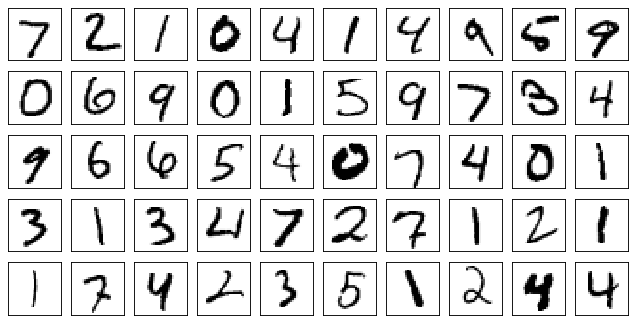

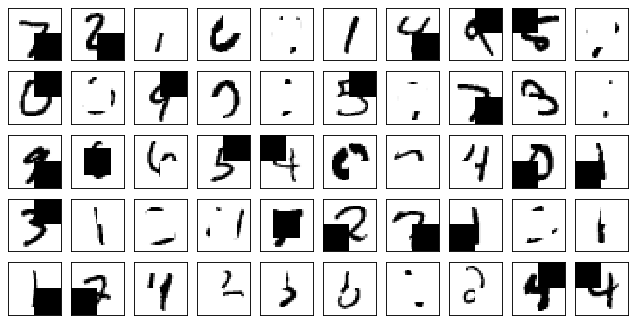

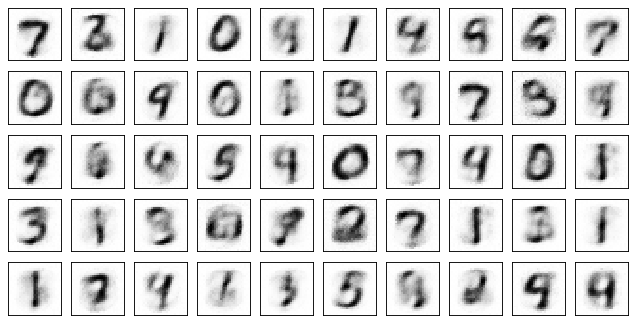

In [ ]:
# Отображение оригинальных изображений MNIST.
plot_mnist(data.data.numpy()[:50], (5, 10))

# Отображение зашумленных изображений.
plot_mnist(noized[:50], (5, 10))

# Отображение восстановленных изображений, полученных после применения автоэнкодера.
plot_mnist(to_plot, (5, 10))


# Шумный автокодировщик

`np.random.randint(4)` является вызовом функции из библиотеки NumPy для генерации случайного целого числа в интервале [0, 4), то есть от 0 до 3 включительно.

Давайте разберем каждую часть выражения:

- `np.random`: Это модуль NumPy, который предоставляет функционал для работы с случайными числами.
- `randint`: Это функция из модуля NumPy для генерации случайных целых чисел.
- `(4)`: Это аргумент функции, который определяет верхнюю границу интервала для генерации случайного числа. В данном случае, это число 4, но как обычно в Python, верхняя граница не включается в интервал, поэтому генерируемое число будет в диапазоне [0, 4).

Таким образом, `np.random.randint(4)` генерирует случайное целое число от 0 до 3 включительно.

In [ ]:
np.random.randint(4)

3

В данном коде определяется функция `add_noise`, которая добавляет случайный шум к входным данным.

Эта функция принимает входные данные `x`, а также параметры `mode` и `elementwise`. В зависимости от переданных параметров, функция добавляет шум к входным данным на уровне изображений или на уровне элементов (пикселей) изображений.

In [ ]:
'''
В данном коде определяется функция add_noise,
которая добавляет случайный шум к входным данным.
'''


def add_noise(x, mode='crop', elementwise=False):
    # Генерируем случайное число от 0 до 1. Если оно равно 1, то возвращаем исходные данные без добавления шума.
    if np.random.randint(2):
        return x
    # Копируем входные данные, чтобы не изменять их напрямую.
    x = x.clone()
    # Если требуется добавление шума на уровне элементов (пикселей), выполняем следующий блок кода.
    if elementwise:
        # Для каждого элемента в батче данных.
        if mode == 'crop':
            # Проходим по каждому изображению в батче.
            for i in range(x.shape[0]):
                # Генерируем случайное число от 0 до 4 для выбора части изображения.
                img_part = np.random.randint(5)
                # Генерируем случайное число от 0 до 1 и преобразуем его в -1 или 1.
                zero_one = np.random.randint(2) * 2 - 1
                # В зависимости от выбранной части изображения заменяем её значения на -1 или 1.
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            # Пока не реализовано. Может быть добавлено зеркальное отражение.
            pass
        elif mode == 'gaussian':
            # Пока не реализовано. Может быть добавлен гауссовский шум.
            pass
    else:
        # Если требуется добавление шума на уровне изображений, выполняем следующий блок кода.
        if mode == 'crop':
            # Генерируем случайное число от 0 до 4 для выбора части изображения.
            img_part = np.random.randint(5)
            # Генерируем случайное число от 0 до 1 и преобразуем его в -1 или 1.
            zero_one = np.random.randint(2) * 2 - 1
            # В зависимости от выбранной части изображения заменяем её значения на -1 или 1 для всех изображений в батче.
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    # Возвращаем данные с добавленным шумом.
    return x


Этот код выполняет предсказания на первых 50 зашумленных изображениях из тестового набора данных с использованием модели, имеющей размер скрытого слоя 64. Полученный вывод преобразуется в форму, совместимую с отображением изображений, для дальнейшей визуализации.

In [ ]:
# Получаем следующий батч данных из тестового загрузчика данных.
data, _ = next(iter(test_loader))

# Добавляем шум к входным данным с помощью функции add_noise.
# Параметр elementwise=True указывает на добавление шума на уровне элементов (пикселей) изображения.
noized = add_noise(data, elementwise=True)

# Применяем модель с размером скрытого слоя 64 к зашумленным данным (первые 50 изображений в батче).
output = models['64'](noized[:50])

# Преобразуем выход модели в форму, совместимую с отображением изображений (каждый элемент представляет собой изображение размером 28x28 пикселей).
to_plot = output.view(-1, 1, 28, 28).data.numpy()


1. `plot_mnist(data.data.numpy()[:50], (5, 10))`:
   - Этот код вызывает функцию `plot_mnist`, которая отображает изображения в формате MNIST.
   - `data.data.numpy()[:50]` - преобразует тензор `data` в массив NumPy и выбирает первые 50 элементов.
   - `(5, 10)` - указывает на формат графика, где будет 5 строк и 10 столбцов, то есть общее количество изображений на графике будет равно 50.

2. `plot_mnist(noized[:50], (5, 10))`:
   - Этот код также вызывает функцию `plot_mnist`, но уже для зашумленных изображений `noized`.
   - `(5, 10)` - опять же указывает на формат графика, где будет 5 строк и 10 столбцов, а значит, общее количество изображений на графике будет также равно 50.

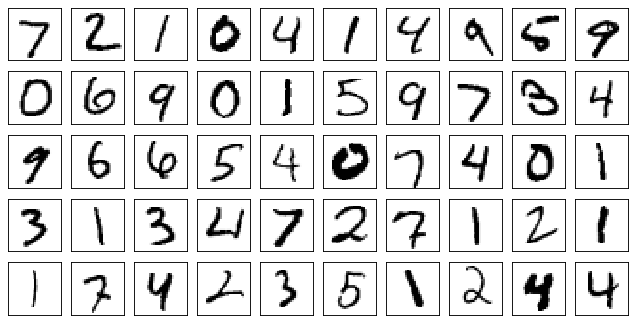

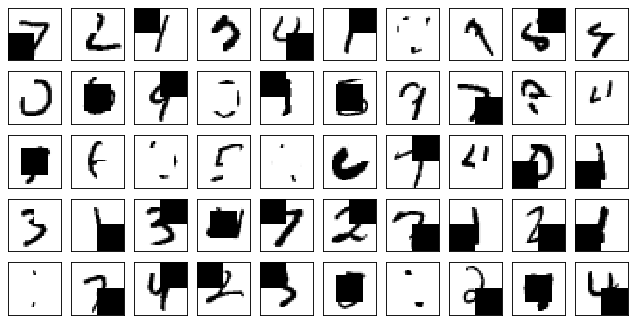

In [ ]:
# Отображение оригинальных изображений MNIST.
plot_mnist(data.data.numpy()[:50], (5, 10))

# Отображение зашумленных изображений.
plot_mnist(noized[:50], (5, 10))

Этот код выполняет цикл обучения и тестирования моделей на протяжении 20 эпох. На каждой итерации сначала все модели устанавливаются в режим обучения (`.train()`), затем происходит обучение моделей на обучающем наборе данных с записью значений функции потерь в `train_log`. После этого все модели устанавливаются в режим оценки (`.eval()`), а затем происходит тестирование моделей на тестовом наборе данных с записью значений функции потерь в `test_log`.

In [ ]:
for epoch in range(1, 21):
    # Цикл по эпохам обучения (от 1 до 20).

    # Устанавливаем все модели в режим обучения (включаем режим обучения).
    for model in models.values():
        model.train()

    # Выполняем обучение моделей на обучающем наборе данных для текущей эпохи.
    # Значения функции потерь записываются в словарь train_log.
    train(epoch, models, train_log)

    # Устанавливаем все модели в режим оценки (выключаем режим обучения, необходимо для того, чтобы влияние шума отключить).
    for model in models.values():
        model.eval()

    # Выполняем тестирование моделей на тестовом наборе данных для текущей эпохи.
    # Значения функции потерь записываются в словарь test_log.
    test(models, test_loader, test_log)


Train Epoch: 1 [00000/60000] 16: 0.998436 32: 0.984344 64: 0.995287
Train Epoch: 1 [30000/60000] 16: 0.829948 32: 0.601609 64: 0.421918
Train Epoch: 1 [60000/60000] 16: 0.620386 32: 0.386238 64: 0.299294
Test set:
16: loss: 0.6215
32: loss: 0.3863
64: loss: 0.2978

Train Epoch: 2 [00000/60000] 16: 0.622973 32: 0.391533 64: 0.306357
Train Epoch: 2 [30000/60000] 16: 0.484340 32: 0.332624 64: 0.291362
Train Epoch: 2 [60000/60000] 16: 0.374337 32: 0.289946 64: 0.267122
Test set:
16: loss: 0.3783
32: loss: 0.2929
64: loss: 0.2708

Train Epoch: 3 [00000/60000] 16: 0.369991 32: 0.284080 64: 0.262814
Train Epoch: 3 [30000/60000] 16: 0.332052 32: 0.284801 64: 0.271279
Train Epoch: 3 [60000/60000] 16: 0.306970 32: 0.276408 64: 0.255192
Test set:
16: loss: 0.3077
32: loss: 0.2767
64: loss: 0.2554

Train Epoch: 4 [00000/60000] 16: 0.313720 32: 0.284384 64: 0.272070
Train Epoch: 4 [30000/60000] 16: 0.297867 32: 0.274653 64: 0.246510
Train Epoch: 4 [60000/60000] 16: 0.289464 32: 0.270044 64: 0.24023

Этот код выполняет предсказания на первых 50 зашумленных изображениях из тестового набора данных с использованием модели, имеющей размер скрытого слоя 64. Полученный вывод преобразуется в форму, совместимую с отображением изображений, для дальнейшей визуализации.

In [ ]:
# Получаем следующий батч данных из тестового загрузчика данных.
data, _ = next(iter(test_loader))

# Добавляем шум к входным данным с помощью функции add_noise.
# Параметр elementwise=True указывает на добавление шума на уровне элементов (пикселей) изображения.
noized = add_noise(data, elementwise=True)

# Применяем модель с размером скрытого слоя 64 к зашумленным данным (первые 50 изображений в батче).
output = models['64'](noized[:50])

# Преобразуем выход модели в форму, совместимую с отображением изображений (каждый элемент представляет собой изображение размером 28x28 пикселей).
to_plot = output.view(-1, 1, 28, 28).data.numpy()




1. `plot_mnist(data.data.numpy()[:50], (5, 10))`:
   - Этот код вызывает функцию `plot_mnist`, которая отображает изображения в формате MNIST.
   - `data.data.numpy()[:50]` - преобразует тензор `data` в массив NumPy и выбирает первые 50 элементов.
   - `(5, 10)` - указывает на формат графика, где будет 5 строк и 10 столбцов, то есть общее количество изображений на графике будет равно 50.

2. `plot_mnist(noized[:50], (5, 10))`:
   - Этот код также вызывает функцию `plot_mnist`, но уже для зашумленных изображений `noized`.
   - `(5, 10)` - опять же указывает на формат графика, где будет 5 строк и 10 столбцов, а значит, общее количество изображений на графике будет также равно 50.

3. `plot_mnist(to_plot, (5, 10))`:
   - Этот код вызывает функцию `plot_mnist`, чтобы отобразить восстановленные изображения, полученные после применения автоэнкодера.
   - `(5, 10)` - опять же указывает на формат графика, где будет 5 строк и 10 столбцов, а значит, общее количество изображений на графике будет также равно 50.

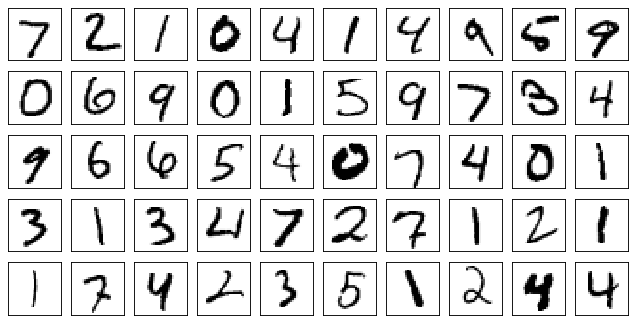

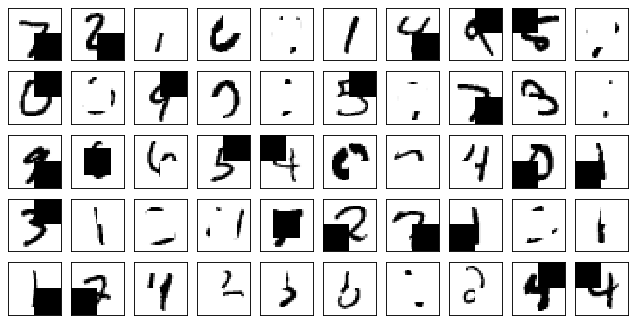

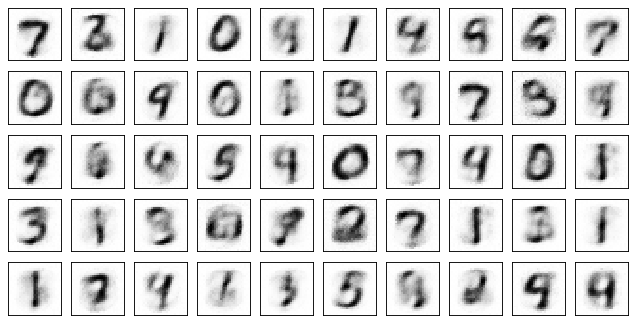

In [ ]:
# Отображение оригинальных изображений MNIST.
plot_mnist(data.data.numpy()[:50], (5, 10))

# Отображение зашумленных изображений.
plot_mnist(noized[:50], (5, 10))

# Отображение восстановленных изображений, полученных после применения автоэнкодера.
plot_mnist(to_plot, (5, 10))
